In [44]:
import os
import nibabel as nib
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [45]:
# ----------- Configuration -----------
IMG_SIZE = 128
VOLUME_START_AT = 60
VOLUME_SLICES = 75
DATA_PATH = "brats20-dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
SAVE_DIR = "./preprocessed"

In [46]:
# ----------- Fix known file inconsistency -----------
rename_src = os.path.join(DATA_PATH, "BraTS20_Training_355", "W39_1998.09.19_Segm.nii")
rename_dst = os.path.join(DATA_PATH, "BraTS20_Training_355", "BraTS20_Training_355_seg.nii")
if os.path.exists(rename_src) and not os.path.exists(rename_dst):
    os.rename(rename_src, rename_dst)
    print("Renamed W39_1998.09.19_Segm.nii → BraTS20_Training_355_seg.nii")

In [47]:
# ----------- Get patient IDs -----------
samples = [s for s in os.listdir(DATA_PATH) if "BraTS20" in s]
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

In [48]:
print(f"Train: {len(samples_train)} | Val: {len(samples_val)} | Test: {len(samples_test)}")

Train: 250 | Val: 74 | Test: 45


In [49]:
# ----------- Load and preprocess data -----------
def process_samples(sample_list, plot_example=False):
    X_all = []
    y_all = []
    
    for i, pid in enumerate(tqdm(sample_list)):
        prefix = os.path.join(DATA_PATH, pid, pid)
        flair = nib.load(prefix + "_flair.nii").get_fdata()
        t1ce = nib.load(prefix + "_t1ce.nii").get_fdata()
        seg = nib.load(prefix + "_seg.nii").get_fdata()

        for j in range(VOLUME_SLICES):
            flair_slice = flair[:, :, j + VOLUME_START_AT]
            t1ce_slice = t1ce[:, :, j + VOLUME_START_AT]
            seg_slice = seg[:, :, j + VOLUME_START_AT]

            # Resize slices
            flair_resized = cv2.resize(flair_slice, (IMG_SIZE, IMG_SIZE))
            t1ce_resized = cv2.resize(t1ce_slice, (IMG_SIZE, IMG_SIZE))
            seg_resized = cv2.resize(seg_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            # Reassign label 4 to 3
            seg_resized[seg_resized == 4] = 3

            # Normalize
            x = np.stack([flair_resized, t1ce_resized], axis=0)
            x_max = np.max(x)
            x = x / x_max if x_max > 0 else x

            X_all.append(torch.tensor(x, dtype=torch.float32))
            y_all.append(torch.tensor(seg_resized, dtype=torch.long))

            # Plot only once
            if i == 0 and j == 0 and plot_example:
                # Save slices for plotting
                flair_orig_for_plot = flair_slice
                flair_resized_for_plot = flair_resized
                seg_resized_for_plot = seg_resized

                # --- Show flair and resized flair
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].imshow(flair_orig_for_plot, cmap='gray')
                axs[0].set_title('Original FLAIR (240x240)')
                axs[1].imshow(flair_resized_for_plot, cmap='gray')
                axs[1].set_title(f'Resized FLAIR ({IMG_SIZE}x{IMG_SIZE})')
                plt.show()

                # --- Show segmentation masks for each class
                fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                class_labels = ['All', 'Class 0 (NT)', 'Class 1 (NCR/NET)', 'Class 2 (ED)', 'Class 3 (ET)']
                axs[0].imshow(seg_resized_for_plot, cmap='tab10')
                axs[0].set_title('Segmentation (all)')

                for k in range(4):
                    mask = np.where(seg_resized_for_plot == k, k, np.nan)
                    axs[k + 1].imshow(mask, cmap='tab10', vmin=0, vmax=3)
                    axs[k + 1].set_title(class_labels[k + 1])

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

    return torch.stack(X_all), torch.stack(y_all)

  0%|          | 0/250 [00:00<?, ?it/s]

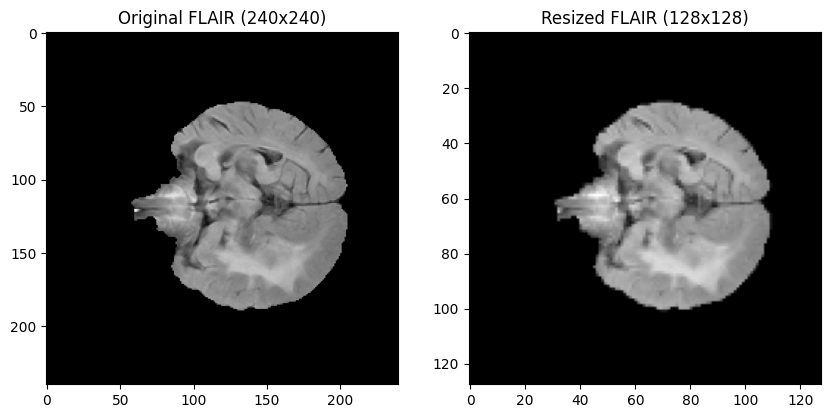

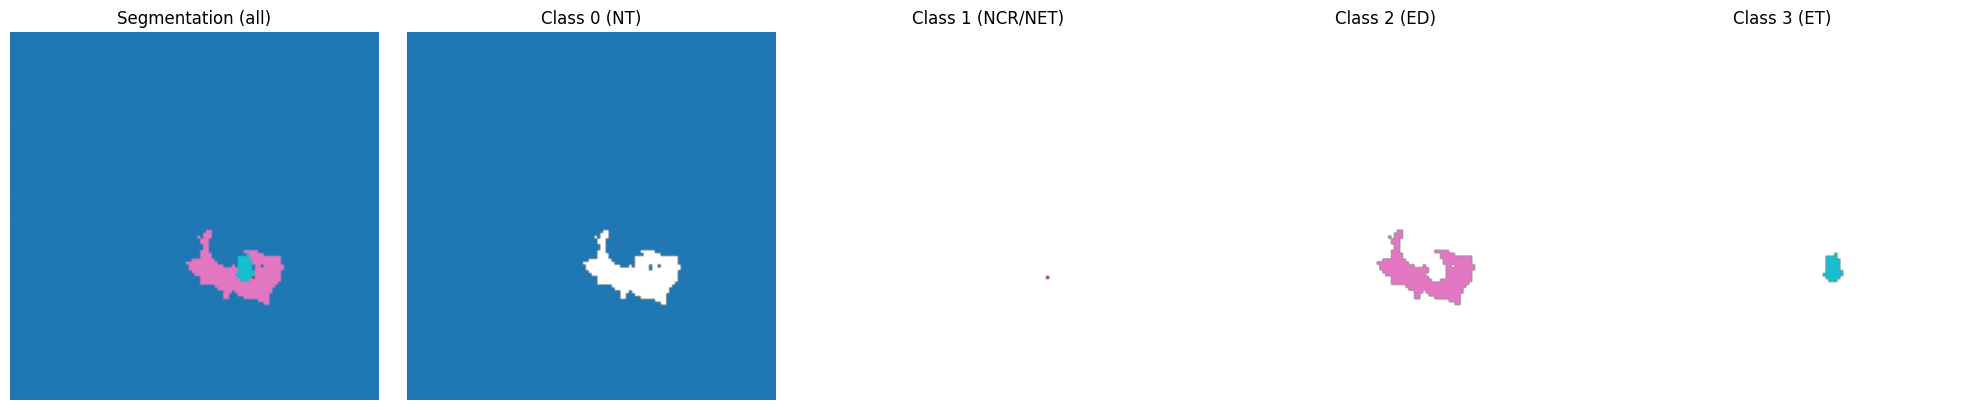

100%|██████████| 45/45 [00:05<00:00,  8.65it/s]


In [50]:
# ----------- Process and save datasets -----------
random.shuffle(samples_train)
X_train, y_train = process_samples(samples_train, plot_example=True)
X_val, y_val = process_samples(samples_val)
X_test, y_test = process_samples(samples_test)

In [51]:
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save((X_train, y_train), os.path.join(SAVE_DIR, "brats_train.pt"))
torch.save((X_val, y_val), os.path.join(SAVE_DIR, "brats_val.pt"))
torch.save((X_test, y_test), os.path.join(SAVE_DIR, "brats_test.pt"))

In [52]:
print("All datasets saved to './preprocessed/' directory.")

All datasets saved to './preprocessed/' directory.
